In [31]:
using Interpolations, Plots, Unitful, StructArrays, UnPack, HDF5
using Flight.Atmosphere: ISA_layers, ISAData, p_std, T_std, g_std, R
using Flight.Geodesy: AltGeop

ω_rated = 2700 #RPM
P_rated = 200 #HP
p_std_inHg = 101325 / 3386.389
fname = "piston.h5"

### Definitions

For implementation, define the following normalized variables
$$\pi = \dfrac{P}{P_{rated}}$$
$$n = \dfrac{\omega}{\omega_{rated}}$$
$$\mu = \dfrac{MAP}{p_{std}}$$

In [ ]:
β = ISA_layers[1].β

δ_from_p(p) = (p/p_std) ^ (1+β*R/(2*g_std)) #computes normalized δ 

function δ_from_h(h) #computes normalized δ
    @unpack p, T = ISAData(AltGeop(h))
    p / p_std / √(T / T_std)
end

@assert δ_from_h(1345) ≈δ_from_p(ISAData(AltGeop(1345)).p)

### Part Throttle Power at Standard Conditions

We need a 2D table providing $\pi_{ISA,std}(n,\mu)$.

From the graph we see that the function $\pi_{ISA,std}(n,\mu)$ is linear in $\mu$. Therefore we need only two data points for each $n$: $(\mu_{1}(n), \pi_{ISA,std}(n,\mu_1(n)))$ and $(\mu_{2}(n), \pi_{ISA,std}(n, \mu_2(n)))$.

However, for a 2D table we need these two $\mu$ values to be the same across all values of $n$. So for each $n$, we construct a 1D linear interpolator, resample $\pi_{std}$ at two $\mu$ values, arbitrary but equal for all $n$, then build the 2D interpolator.

For $n > 1$, if we were to simply extrapolate the values in the graph, power would increase indefinitely with engine speed, which we know is not realistic. To avoid this, we add two extra $\pi$ entries at $n_{N+2}, n_{N+1} > 1$, with power reaching a peak between $n_{N}$ and $n_{N+1}$, then decreasing between $n_{N+1}$ and $n_{N+2}$, both for $\mu_1$ and $\mu_2$. The values of $\mu_1$ and $\mu_2$ for these synthetic $n$ values are simply extrapolations. 


In [41]:
@show n_range = range(1500, 2700, step = 100)/ω_rated
@show n_range_ext = range(1800, 2900, step = 100)/ω_rated
@show μ_range_std = range(17, 30, length = 2) / p_std_inHg

@show μ_std_1 = fill!(similar(n_range_ext), 17) / p_std_inHg
@show μ_std_2 = [25 25.55 26.15 26.88 27.3 28.1 28.75 28.7 28.65 28.6 28.55 28.50] / p_std_inHg |> vec
@show π_ISA_std_1 = [54 61 67 72 76 81 85 90 94.1 99.5 99.5 96.1] / P_rated  |> vec
@show π_ISA_std_2 = [97.8 109.5 121.8 136 145.75 162 176 184 193 200 200 193] / P_rated |> vec

π_ISA_std_data = Array{Float64,2}(undef, (length(n_range_ext), length(μ_range_std)))
for (i, n) in enumerate(n_range_ext)
    interp_π_ISA_std_1D = LinearInterpolation([μ_std_1[i], μ_std_2[i]], [π_ISA_std_1[i], π_ISA_std_2[i]], extrapolation_bc = Line())
    π_ISA_std_data[i,:] = interp_π_ISA_std_1D.(μ_range_std)
end

interp_π_ISA_std = extrapolate(scale(interpolate(π_ISA_std_data, BSpline(Linear())), n_range_ext, μ_range_std), Line())
@show interp_π_ISA_std(2400/ω_rated, 24/p_std_inHg) * P_rated
@show interp_π_ISA_std(1000/ω_rated, 16/p_std_inHg) * P_rated


h5open(fname, "w") do fid

    create_group(fid, "pi_ISA_std")
    π_ISA_std = fid["pi_ISA_std"]

    π_ISA_std["n"] = collect(n_range)
    π_ISA_std["mu"] = collect(μ_range_std)
    π_ISA_std["data"] = π_ISA_std_data

end


n_range = range(1500, 2700, step = 100) / ω_rated = 0.5555555555555556:0.037037037037037035:1.0
n_range_ext = range(1800, 2900, step = 100) / ω_rated = 0.6666666666666666:0.037037037037037035:1.0740740740740742
μ_range_std = range(17, 30, length = 2) / p_std_inHg = 0.5681580360226992:0.43447379225265237:1.0026318282753517
μ_std_1 = fill!(similar(n_range_ext), 17) / p_std_inHg = [0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992]


μ_std_2 = [25 25.55 26.15 26.88 27.3 28.1 28.75 28.7 28.65 28.6 28.55 28.5] / p_std_inHg |> vec = [0.835526523562793, 0.8539081070811745, 0.8739607436466814, 0.898358118134715, 0.9123949637305699, 0.9391318124845793, 0.9608555020972119, 0.9591844490500864, 0.9575133960029607, 0.9558423429558353, 0.9541712899087096, 0.952500236861584]
π_ISA_std_1 = [54 61 67 72 76 81 85 90 94.1 99.5 99.5 96.1] / P_rated |> vec = [0.27, 0.305, 0.335, 0.36, 0.38, 0.405, 0.425, 0.45, 0.4705, 0.4975, 0.4975, 0.4805]
π_ISA_std_2 = [97.8 109.5 121.8 136 145.75 162 176 184 193 200 200 193] / P_rated |> vec = [0.489, 0.5475, 0.609, 0.68, 0.72875, 0.81, 0.88, 0.92, 0.965, 1.0, 1.0, 0.965]


interp_π_ISA_std(2400 / ω_rated, 24 / p_std_inHg) * P_rated = 139.2127659574468
interp_π_ISA_std(1000 / ω_rated, 16 / p_std_inHg) * P_rated = -7.474999999999961


12×2 Matrix{Float64}:
 0.27    0.625875
 0.305   0.673713
 0.335   0.72429
 0.36    0.781053
 0.38    0.82017
 0.405   0.879324
 0.425   0.928404
 0.45    0.972222
 0.4705  1.0223
 0.4975  1.06065
 0.4975  1.06308
 0.4805  1.0282

### Wide-Open Throttle Power and MAP at Altitude

We need a 2D interpolator $\delta_{wot}(\bar{n}, \bar{M})$, which we'll use later to find $\delta_{ref}$.

In [34]:
μ_range_wot = range(12, 28, step = 2)/p_std_inHg #24 26 28
n_1_wot = 1800/ω_rated
n_2_wot = 2700/ω_rated

#take the pressure altitude values in kft read from the graph and convert them
#to meters
h_wot_1 = ustrip.(u"m", [22.2, 18.55, 15.4, 12.5, 9.8, 7.35, 5.1, 3.00, 1.1]*1000u"ft")
h_wot_2 = ustrip.(u"m", [21.7, 18.2, 15.0, 12.1, 9.45, 6.95, 4.7, 2.5, 0.6]*1000u"ft")

#compute the corresponding δ values
@show δ_wot_1 = δ_from_h.(h_wot_1)
@show δ_wot_2 = δ_from_h.(h_wot_2)

#higher RPM require slightly higher ambient pressure (and therefore higher δ) to
#achieve a given MAP, because the manifold vacuum increases with RPM

δ_wot_data = Array{Float64}(undef, length(n_range), length(μ_range_wot))
for (i, μ) in enumerate(μ_range_wot)
    interp_δ_wot_1D = LinearInterpolation([n_1_wot, n_2_wot], [δ_wot_1[i], δ_wot_2[i]], extrapolation_bc = Line())
   δ_wot_data[:,i] = interp_δ_wot_1D.(n_range)
end

interp_δ_wot = extrapolate(scale(interpolate(δ_wot_data, BSpline(Linear())), n_range, μ_range_wot), Line())

@show interp_δ_wot(2400/ω_rated, 24/p_std_inHg), δ_from_h(4850*0.3048)
@show interp_δ_wot(2100/ω_rated, 20/p_std_inHg), δ_from_h(9600*0.3048)
@show interp_δ_wot(1800/ω_rated, 28/p_std_inHg), δ_from_h(1200*0.3048)
@show interp_δ_wot(1, 28.65/p_std_inHg), compute_δ_h(0*0.3048)

h5open(fname, "w") do fid

    create_group(fid, "delta_wot")
    δ_wot = fid["delta_wot"]

    δ_wot["n"] = collect(n_range)
    δ_wot["mu"] = collect(μ_range_wot)
    δ_wot["data"] = δ_wot_data

end

δ_wot_1 = δ_from_h.(h_wot_1) = [0.45488826288341005, 0.5226221765054068, 0.5872662297982473, 0.652213060817433, 0.7176582379283565, 0.7814324368713697, 0.8438661990455512, 0.9056301912743312, 0.9645379356818949]
δ_wot_2 = δ_from_h.(h_wot_2) = [0.46373238813431905, 0.5295134805614843, 0.5959069556786906, 0.6615988634589004, 0.726507891003391, 0.7922561322993095, 0.855366275187289, 0.9208488318821639, 0.9805317464835176]
(interp_δ_wot(2400 / ω_rated, 24 / p_std_inHg), δ_from_h(4850 * 0.3048)) = (0.8515329164733765, 0.851039335842428)
(interp_δ_wot(2100 / ω_rated, 20 / p_std_inHg), δ_from_h(9600 * 0.3048)) = (0.7206081222867012, 0.7227046924579216)
(interp_δ_wot(1800 / ω_rated, 28 / p_std_inHg), δ_from_h(1200 * 0.3048)) = 

(0.9645379356818949, 0.9613640450620135)
(interp_δ_wot(1, 28.65 / p_std_inHg), compute_δ_h(0 * 0.3048)) = (0.9999286937289575, 1.0)


10×9 Matrix{Float64}:
 0.454888  0.522622  0.587266  0.652213  …  0.843866  0.90563   0.964538
 0.455871  0.523388  0.588226  0.653256     0.845144  0.907321  0.966315
 0.456854  0.524154  0.589186  0.654299     0.846422  0.909012  0.968092
 0.457836  0.524919  0.590146  0.655342     0.8477    0.910703  0.969869
 0.458819  0.525685  0.591107  0.656385     0.848977  0.912394  0.971646
 0.459802  0.526451  0.592067  0.657427  …  0.850255  0.914085  0.973423
 0.460784  0.527216  0.593027  0.65847      0.851533  0.915776  0.9752
 0.461767  0.527982  0.593987  0.659513     0.852811  0.917467  0.976978
 0.46275   0.528748  0.594947  0.660556     0.854088  0.919158  0.978755
 0.463732  0.529513  0.595907  0.661599     0.855366  0.920849  0.980532

We also need the inverse table $MAP_{wot}(n,d)$ for the $MAP(thr,d,n)$ computation.

To do this, we can proceed as we did for the part-throttle table: for each $\bar{n}$ obtain a 1D linear interpolator $MAP_{wot,1D}(\delta)$. Then evaluate it at some predefined $\delta$ range. Finally, use the results for all $n$ values to construct the 2D interpolator $MAP_{wot}(n, \delta)$.

In [ ]:
δ_range_wot = range(δ_from_h(23e3*.3048), 1, length = 100)

μ_wot_data = Array{Float64}(undef, length(n_range), length(δ_range_wot))
for (i, n) in enumerate(n_range)
    δ_wot_1D = interp_δ_wot(n, μ_range_wot)
    interp_μ_wot_1D = LinearInterpolation(δ_wot_1D, μ_range_wot, extrapolation_bc = Line())
    μ_wot_data[i, :] = interp_μ_wot_1D.(δ_range_wot)
end

interp_μ_wot = extrapolate(scale(interpolate(μ_wot_data, BSpline(Linear())), n_range, δ_range_wot), Line())

@show interp_μ_wot(1, interp_δ_wot(1, 1))
@show interp_μ_wot(1800/ω_rated, δ_from_h(12500*0.3048)) * p_std_inHg
@show interp_μ_wot(2050/ω_rated, δ_from_h(5000*0.3048)) * p_std_inHg

h5open(fname, "w") do fid

    create_group(fid, "mu_wot")
    μ_wot = fid["mu_wot"]

    μ_wot["n"] = collect(n_range)
    μ_wot["delta"] = collect(δ_range_wot)
    μ_wot["data"] =μ_wot_data

end

Is it justified for the $\mu_{wot}(n,\delta)$ and $\delta_{wot}(n,\mu)$ mappings to be extrapolated linearly? We can reason this with $\mu_{wot}(n,\delta)$; since one mapping is the inverse of the other, and they are linear, the conclusion will apply for both of them. For a given $n$, as $\delta$ grows, $\mu_{wot}$ will keep growing indefinitely, since the air pressure keeps increasing. And for a given $\delta$, as $n$ grows, $\mu_{wot}$ will also keep falling indefinitely, since the engine sucks more air and the manifold vacuum increases. The fact that the brake power decreases due to increasing losses for $n > 1$ does not change these facts.


In [28]:
#read from the right graph
π_ISA_wot_1 = [46 51.5 56 59.9 63.8 66.2 70.6 76 78.6 81.8 81.8 78.6] / P_rated |> vec

#to ensure consistency with π_ISA_std, to obtain the δ = 1 points we evaluate π_ISA_std(n,
#μ) with μ = μ_wot(n, δ = 1), instead of reading them from the graph
π_ISA_wot_2 = [interp_π_ISA_std(n, interp_μ_wot(n, 1)) for n in n_range_ext]

π_ISA_wot_data = hcat(π_ISA_wot_1, π_ISA_wot_2)

interp_π_ISA_wot = extrapolate(scale(interpolate(π_ISA_wot_data, BSpline(Linear())), n_range_ext, δ_range_wot), Line())

@show interp_π_ISA_wot(2300/ω_rated, δ_from_h(24000*.3048))*P_rated
@show interp_π_ISA_wot(1900/ω_rated, δ_from_h(12000*.3048))*P_rated

# h5open(fname, "w") do fid

#     create_group(fid, "mu_wot")
#     μ_wot = fid["mu_wot"]

#     μ_wot["n"] = collect(n_range)
#     μ_wot["delta"] = collect(δ_range_wot)
#     μ_wot["data"] =μ_wot_data

# end


interp_π_ISA_wot(2300 / ω_rated, δ_from_h(24000 * 0.3048)) * P_rated = 63.133698418159966
interp_π_ISA_wot(1900 / ω_rated, δ_from_h(12000 * 0.3048)) * P_rated = 82.75947844888427


82.75947844888427

In [ ]:
function test_π_ISA_wot(ω_RPM, h_ft)
    n = ω_RPM/ω_rated
    h = h_ft * 0.3048
    @show δ = δ_from_h(h)
    @show interp_π_ISA_wot(n, δ) * P_rated
end

test_π_ISA_wot(2700, 11000)
test_π_ISA_wot(2200, 7000)
test_π_ISA_wot(2600, 16000)

In [ ]:
# function compute_Pbar_ISA(thr, nbar, δ)

#     #compute the wide-open throttle MAP for the given RPMs and altitude
#     @show Mbar_wot = interp_Mbar_wot(nbar, δ)
#     idle_MAP_ratio = 0.4
#     #this can be tuned so that the engine idles at appropriate RPMs with the
#     #chosen propeller
#     @show Mbar = Mbar_wot * (idle_MAP_ratio + thr * (1 - idle_MAP_ratio))

#     #δ at which our Mbar would be Mbar_wot
#     @show δ_wot = interp_δ_wot(nbar, Mbar)

#     Pbar_ISA_std = interp_Pbar_ISA_std(nbar, Mbar)
#     Pbar_ISA_wot = interp_Pbar_ISA_wot(nbar, δ_wot)
#     @show P_ISA_std = Pbar_ISA_std * P_rated
#     @show P_ISA_wot = Pbar_ISA_wot * P_rated
    
#     #when p_wot is close to p_std with MAP = MAP_wot (thr = 1),
#     #p_wot(MAP_wot(p_std)) = p_std and P̃_wot = P̃_std. we need to avoid the
#     #division by zero
#     @show abs(δ_wot - 1)
#     if abs(δ_wot - 1) < 1e-3
#         @show "Hi"
#         Pbar_ISA = Pbar_ISA_std
#     else
#         Pbar_ISA = Pbar_ISA_std + (Pbar_ISA_wot - Pbar_ISA_std) / (δ_wot - 1) * (δ - 1)
#         @show Pbar_ISA_std
#     end

#     @show P_ISA = Pbar_ISA * P_rated
#     @show MAP = Mbar * MAP_rated
#     @show δ = Mbar * MAP_rated

#     return max(0, Pbar_ISA)

# end


In [ ]:
thr_test = 1
nbar_test = 2700/n_rated
δ_test = compute_δ_h(30000 * 0.3048)
compute_Pbar_ISA(thr_test, nbar_test, δ_test) * P_rated

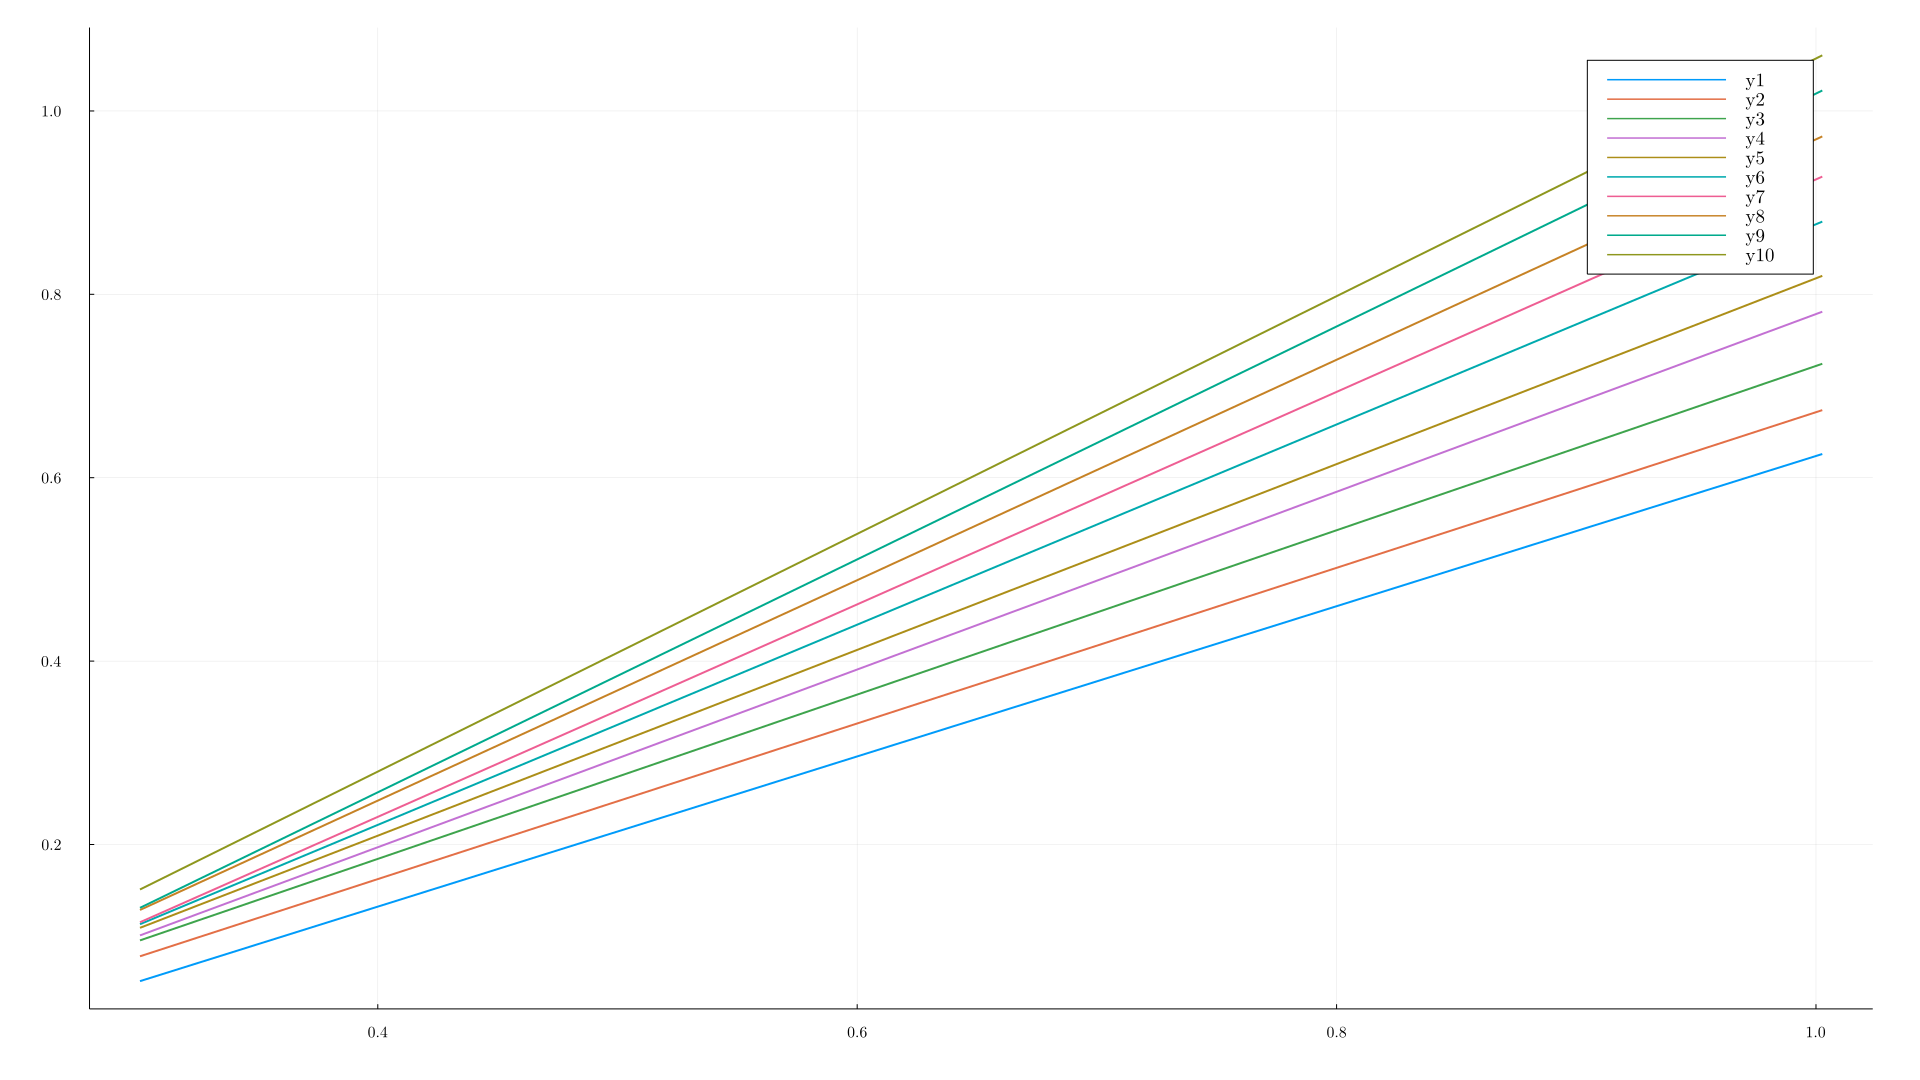

In [48]:
#plot minimum and maximum sea level power across RPM
n_plot = range(1800, 2700, step = 100)/ω_rated
δ_plot = range(1, δ_from_h(24000*0.3048), length = 100)
μ_plot = range(9, 30, length = 30)/p_std_inHg

π_std_plot = [interp_π_ISA_std(n, μ) for (n, μ) in Iterators.product(n_plot, μ_plot)]
plot(μ_plot, π_std_plot')

In [ ]:
δ_wot_plot = [interp_δ_wot(n,μ) for (n,μ) in Iterators.product(n_plot, μ_plot)]
plot(μ_plot, δ_wot_plot')

In [ ]:
μ_wot_plot = [interp_μ_wot(n,p) for (n,p) in Iterators.product(n_plot, δ_plot)]
plot(δ_plot, μ_wot_plot')

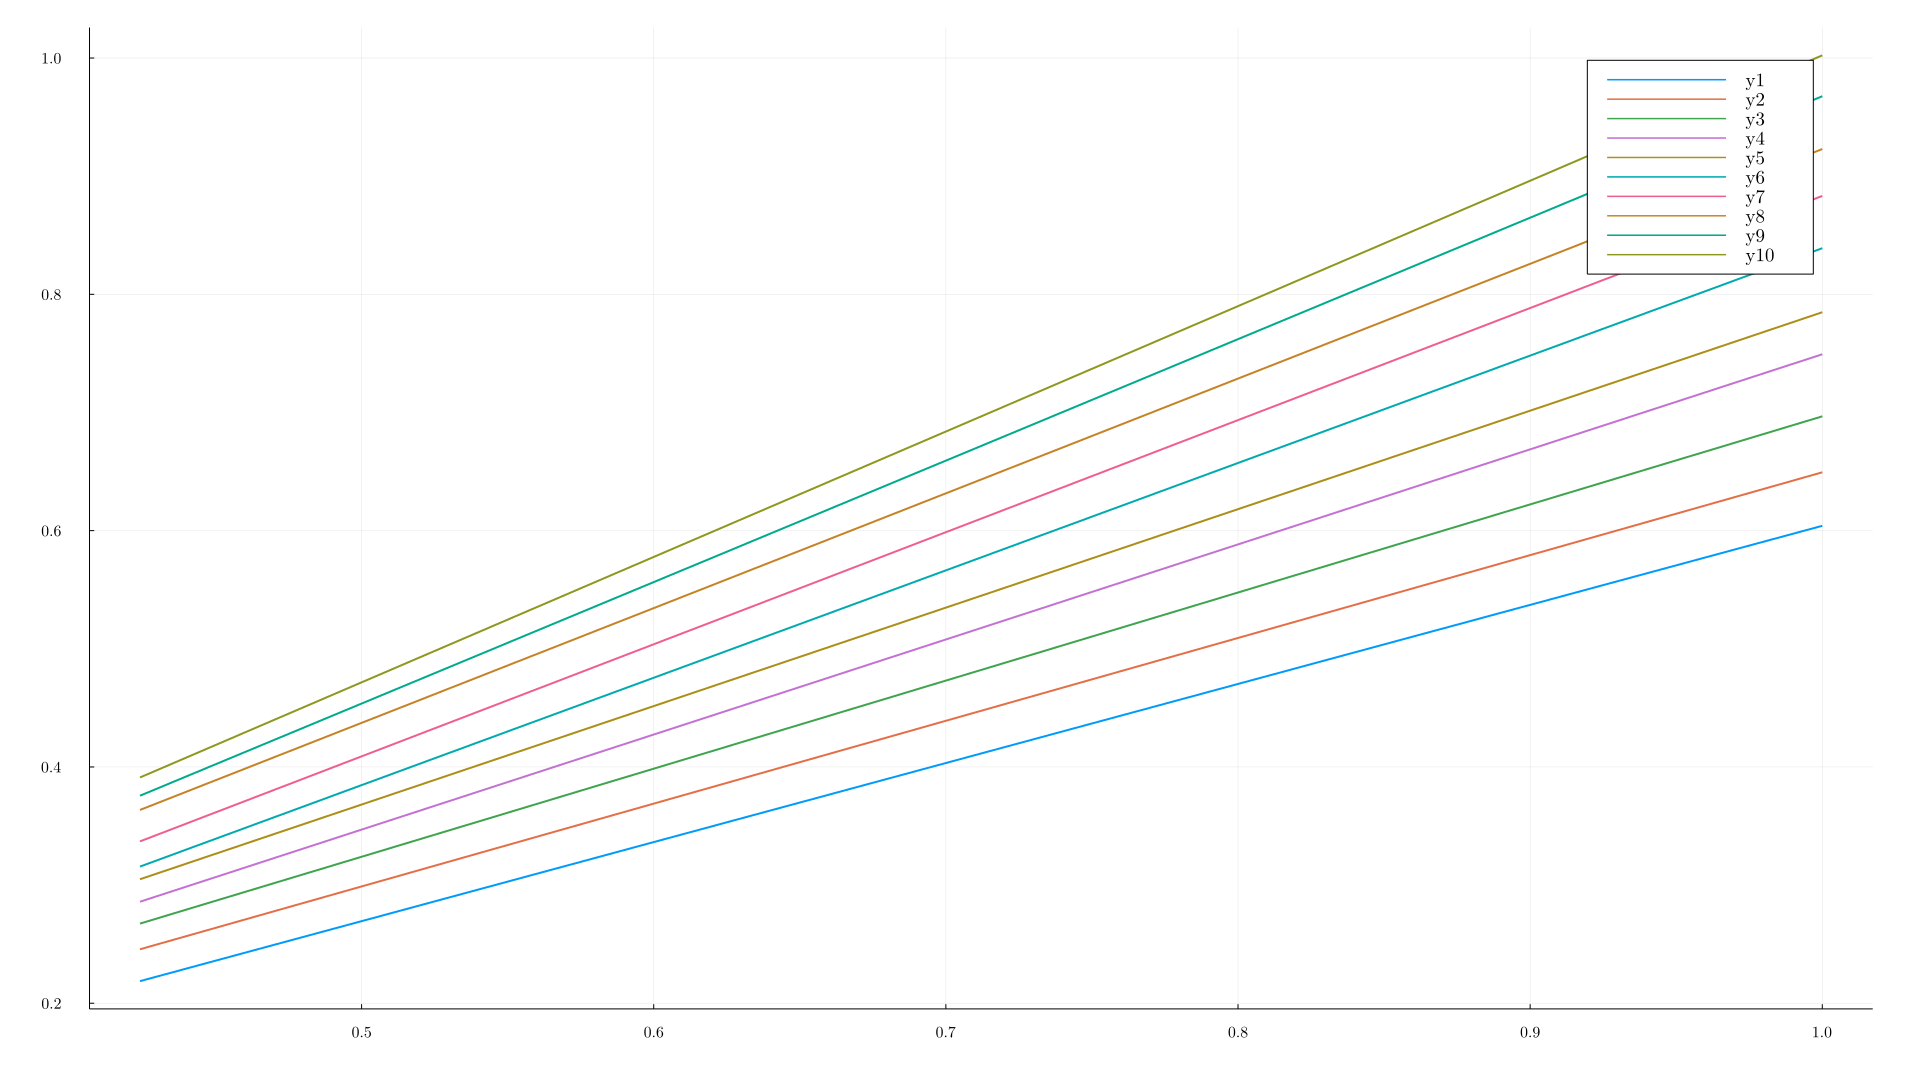

In [50]:
π_wot_plot = [interp_π_ISA_wot(n,p) for (n,p) in Iterators.product(n_plot, δ_plot)]
plot(δ_plot, π_wot_plot')

In [ ]:
h5open("piston_engine.h5", "w") do f
    f["interp_pi_std"] = A_final
end